In [1]:
#!pip uninstall tensorflow -y;
#!yes | pip install tensorflow-probability==0.23;
#!yes | pip install tensorflow==2.15;
!yes | pip install hyperopt

In [2]:

#importing libraries

import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import matplotlib.pyplot as plt
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
import scipy.optimize as spo
import time
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
import requests
import json
from hyperopt import fmin, tpe, hp, Trials
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# class for technical indicators. I receives a dataframe and returns, for each method,
# a new column with the values calculated based on an input column.

class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df.loc[offset:,column]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum

        return self.df[f'{column}_momentum_{n}']

    # moving average of column i of returns through n days
    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df.loc[offset:,column].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']

    # calculate upper and lower 2*std_deviation lines
    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band

    # moving average and +/- 2*std_deviation lines
    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df.loc[offset:,column].rolling(window_size).mean()
            self.df.loc[0:window_size,f'{column}_mm20'] =  self.df.loc[window_size,f'{column}_mm20']
            rstd = self.df.loc[offset:,column].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]

    # daily and cumulative returns of column
    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df.loc[0,f'{column}_daily_return'] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df.loc[0,f'{column}_cumulative_return'] = 0

    # log return after n days of column
    def log_returns(self,column,n):
        self.df[f'{column}_log_return_{n}'] = np.log((self.df[column] / self.df[column].shift(n)))
        self.df.loc[0:n,f'{column}_log_return_{n}'] = self.df.loc[n,f'{column}_log_return_{n}']
        return self.df[f'{column}_log_return_{n}']



In [5]:
# get stock (ticker) data from yahoo finance from start to end dates
class stock_dataframe():
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        self.start = start
        self.end = end

#    def conv_df(resp):
#        j = resp.json()
#        data = [j['chart']['result'][0]['timestamp']] + list(j['chart']['result'][0]['indicators']['quote'][0].values() + list(j['chart']['result'][0]['indicators']['adjclose'][0].values())
#        df = pd.DataFrame(
#        {'timestamp': data[0], 'close': data[1], 'open': data[2], 'high': data[3], 'low': data[4], 'volume': data[5], 'adjclose': data[6]})
#        df['time'] = pd.to_datetime(df['timestamp'], unit='s')
#        df['date'] = df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
#        return df

    def get_stock_data(self):
        start_date = date.fromisoformat(self.start)
        end_date = date.fromisoformat(self.end)
        start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
        end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
        print(start_date, end_date)
        #self.start_stamp = datetime.timestamp(self.start_date)
        #self.end_stamp = datetime.timestamp(self.end_date)
        print(start_stamp,end_stamp)
        url = "https://query2.finance.yahoo.com/v8/finance/chart/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedclose=true" % (self.ticker,start_stamp,end_stamp)
        print(url)
        response = requests.get(url,headers = {'User-agent': 'Request %s' % self.ticker})
        data = response.json()
        result = data["chart"]["result"][0]
        stock = pd.DataFrame(result["indicators"]["quote"][0])
        stock['adjclose'] = result["indicators"]["adjclose"][0]["adjclose"]
        stock['date'] = pd.to_datetime(result["timestamp"], unit='s')
        self.stock = stock.dropna()
        #print(json.dumps(data, indent=4))
        #data = json.loads(response.text)
        #self.stock = pd.read_csv(url)
       # self.stock = pd.json_normalize(response.json())
        print(self.stock)
        self.stock["relhigh"] = self.stock["high"]/self.stock["adjclose"]
        self.stock["rellow"] = self.stock["low"]/self.stock["adjclose"]
        self.stock["relopen"] = self.stock["open"]/self.stock["adjclose"]
        return self.stock

    # Convert Date to Day, Month and Year columns.
    def Date_Convert(self):
        self.stock['date'] = pd.to_datetime(self.stock['date'])
        self.stock['year'] = self.stock['date'].dt.year
        self.stock['month'] = self.stock['date'].dt.month
        self.stock['day'] = self.stock['date'].dt.day

    # define Scaler
    def Standard_Scaler(self):
        self.scaler = StandardScaler()

    def Min_Max_Scaler(self):
        self.scaler = MinMaxScaler()

    # Calculate technical indicators
    def Get_Technical_Indicators(self,price):
        TI = TechnicalIndicators(self.stock)
        TI.momentum(price,15)
        TI.simple_movement_average(price,15)
        TI.bollinger_bands(price,15)
        TI.add_daily_return(price)
        TI.log_returns(price,1)
        self.stock = TI.df
        return self.stock

    # Perform Chosen normalization
    def Normalize(self):
        # Define the column to leave unchanged
        unchanged_column = 'date'

        # Create a subset of columns excluding the unchanged column
        columns_to_scale = [col for col in self.stock.columns if col != unchanged_column]

        # Copy the DataFrame
        stock_normalized = self.stock.copy()

        # Apply StandardScaler to the subset of columns
        stock_normalized[columns_to_scale] = self.scaler.fit_transform(self.stock[columns_to_scale])

        #print(stock_normalized)

        # Concatenate the normalized subset with the unchanged column
        stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)

        # rename adjusted close to avoid spaces

        return stock_normalized



In [6]:
# Merge stock dataframes for all options in a single dataframe
def merge_stocks(options):
    df = pd.DataFrame()
    for stock in options:
        #print("stock =",stock)
        # define stock data class
        stock_data = stock_dataframe(stock,"2010-01-01","2022-12-31")

        # read data
        stock_data.get_stock_data()

        # convert Date to Day, Month and Year columns
        stock_data.Date_Convert()

        # Calculate additional variables
        stock_data.Get_Technical_Indicators("adjclose")

        #print("stock_data.stock = ",stock_data.stock)
        # Apply normalization
        date_columns = ["date","year","month","day"]
        df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()
        # Identify columns with identical values across all DataFrames
        identical_columns = []
        distinct_columns = []

        # merge with other options
        for col in df_stock.columns:
            if (col in df and col in df_stock):
                if df[col].equals(df_stock[col]): identical_columns.append(col)
            else:
                if col not in date_columns: df_stock.rename(columns={col: stock + '_' + col}, inplace=True)
        # Identify columns with distinct values across the DataFrames
        distinct_columns = [col for col in df_stock.columns if col not in identical_columns]

        df = pd.concat([df,df_stock[distinct_columns]],axis=1)
    #print(df)
    return df

In [7]:
# Class for calculating option weights for an optimal portfolio for each day
class PortfolioOptimization:
    def __init__(self, data_frame, options):
        self.df = data_frame.copy()
        self.options = options.copy()
        self.init_weights()

     # initialize weights
    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1 / len(self.options)

    # constraints for optimization. Might not be needed in case W_i/sum(W_i) is used
    def _constraints(self, weights):
        return np.sum(weights) - 1

    # Sharpe ration calculation of the full portfolio. Currently using constant as risk free return
    def sharpe_ratio(self, weights, returns, std, rfree):
        norm_weights = weights / np.sum(weights)
        total_return = np.sum(norm_weights * returns)
        portfolio_stddev = np.sum(norm_weights*norm_weights*std*std)
        return (total_return - rfree) / portfolio_stddev

    # Minimize target funcion, maximizing the Sharpe ratio
    def target_function(self, weights, returns, stddev, rfree):
        return -self.sharpe_ratio(weights, returns, stddev, rfree)

    # weight optimization using scikit.optmize.minimize. Might not be the best choice, still can test alternatives. Need to check optimized values
    def optimize_weights(self, weights, returns, stddev, rfree):
        constraints = {'type': 'eq', 'fun': self._constraints}
        bounds = [(0, 1) for _ in range(len(weights))]

        result = spo.minimize(
            self.target_function,
            weights,
            args=(returns, stddev, rfree),
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'  # Sequential Least Squares Programming optimizer
        )

        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        return result.x

    # Apply optimization for each row.
    def get_optimal_weights(self, rfree):
        weight_columns = [col for col in self.df.columns if col.endswith('_weight')]
        return_columns = [col.replace('_weight', '_adjclose_log_return_1') for col in weight_columns]
        stddev_columns = [self.df[col].std() for col in return_columns]

        def apply_optimization(row):
            weights = row[weight_columns].values
            returns = row[return_columns].values
            optimal_weights = self.optimize_weights(weights, returns, stddev_columns, rfree)
            return pd.Series(optimal_weights, index=weight_columns)

        # df.apply was tricky to use with a function with many parameters, to be applied in many columns. This was the workaround which worked
        self.df[weight_columns] = self.df.apply(apply_optimization, axis=1)
        return self.df[weight_columns]

In [8]:
# class for calculating evaluation metrics of the model
class Metrics():
    def __init__(self, in_df, pred_df, targets):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.targets = targets.copy()
        self.out = pd.DataFrame()
        self.mse = {}

    # pull = (predicted - data)/std_dev
    def pull(self):
        for column in self.targets:
            # Ensure both return Series
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull
        return self.out.filter(like='Pull')

    # chisq = (predicted - data)**2/std_dec**2
    def chisq(self):
        for column in self.targets:
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
        return self.out.filter(like='ChiSq')

    # mse = sum(chisq)/n_rows for every row
    def get_mse(self):
        for column in self.targets:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])
        return self.mse

In [9]:
class data_prep():
    def __init__(
        self,
        df,
        features,
        targets,
        train_fraction=0.5,
        validation_fraction=0.25,
        rwin=7,
        offset=1,
    ):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset

    def calculate_metrics(self):
        Met = Metrics(self.Train_Dat[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        return self

    def create_sequences(self):
        self.sequences = []
        self.featureval = self.df[self.features].values
        for start_idx in range(len(self.featureval) - self.rwin + 1):
            end_idx = start_idx + self.rwin
            sequence = self.featureval[start_idx:end_idx]
            self.sequences.append(sequence)

        return self.sequences

    def create_targetval(self):
        self.targetval = self.df[self.targets].values
        return self.targetval

    def split_data(self):
        train_split = int((len(self.targetval) - self.rwin)*self.train_fraction)
        validation_split = int((len(self.targetval) - self.rwin)*self.validation_fraction)
        train_sequences = self.sequences[:train_split]
        validation_sequences = self.sequences[train_split:train_split + validation_split]
        test_sequences = self.sequences[train_split + validation_split:]
        train_targets = self.targetval[self.rwin+self.offset:self.rwin+self.offset + train_split]
        validation_targets = self.targetval[self.rwin+self.offset + train_split:self.rwin+self.offset + train_split + validation_split]
        test_targets = self.targetval[self.rwin+self.offset + train_split + validation_split:]
        #print("len(self.sequences) = ", len(self.sequences))
        #print("len(self.targetval) = ", len(self.targetval))
        #print("self.rwin = ", self.rwin)
        #print("self.train_fraction = ", self.train_fraction)
        #print("self.validation_fraction = ", self.validation_fraction)
        #print("train_split = ", train_split)
        #print("valdation_split = ", validation_split)
        train_sequences = np.asarray(train_sequences).astype('float32')
        validation_sequences = np.asarray(validation_sequences).astype('float32')
        test_sequences = np.asarray(test_sequences).astype('float32')
        train_targets = np.asarray(train_targets).astype('float32')
        validation_targets = np.asarray(validation_targets).astype('float32')
        test_targets = np.asarray(test_targets).astype('float32')
        #print("data_prep:train_sequences.shape = ", train_sequences.shape)
        return train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets


In [10]:
options = ["ITUB4.SA",
           "VALE3.SA"
          ]
prices = ["VALE3.SA_adjclose_log_return_1","ITUB4.SA_adjclose_log_return_1"]
features = ["VALE3.SA_adjclose_log_return_1","VALE3.SA_relhigh","VALE3.SA_rellow","ITUB4.SA_adjclose_log_return_1","ITUB4.SA_relhigh","ITUB4.SA_rellow"]
targets = ["VALE3.SA_adjclose_log_return_1","ITUB4.SA_adjclose_log_return_1"]


In [11]:
df = merge_stocks(options)
df.index.start

#print("df = ",df)

port = PortfolioOptimization(df,options)
port.init_weights()
weights = port.get_optimal_weights(0.00)
print("weights = ", weights)
print("port.df = ",port.df)

df = port.df

2010-01-01 2022-12-31
1262304000 1672444800
https://query2.finance.yahoo.com/v8/finance/chart/ITUB4.SA?period1=1262304000&period2=1672444800&interval=1d&events=history&includeAdjustedclose=true
        volume       open       high        low      close   adjclose  \
0     11843397  17.708261  18.436810  17.708261  18.268333  10.111694   
1      8593315  18.313868  18.386723  18.168158  18.386723  10.177226   
2     10602572  18.327526  18.436810  18.077089  18.227352  10.089014   
3      9966567  18.099855  18.236460  18.008787  18.040663   9.985677   
4      9748709  18.113516  18.113516  17.721922  17.767456   9.834455   
...        ...        ...        ...        ...        ...        ...   
3220  25327300  25.030001  25.510000  24.870001  25.190001  22.642214   
3221  15730800  24.950001  25.180000  24.549999  24.690001  22.192787   
3222  17203600  24.660000  24.730000  24.270000  24.549999  22.066942   
3223  22696400  24.750000  25.200001  24.520000  25.049999  22.516369   
322

<ipython-input-6-e9e9088e41d8>:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()
<ipython-input-6-e9e9088e41d8>:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()


          close       open    volume       high        low   adjclose  \
0     51.490002  50.189999   2381400  51.490002  49.799999  22.555254   
1     51.970001  51.540001   3001800  52.540001  51.240002  22.765514   
2     53.070000  52.000000   2742800  53.369999  51.779999  23.247372   
3     53.290001  52.509998   2543100  53.540001  52.500000  23.343737   
4     53.810001  53.299999   2444500  54.240002  53.000000  23.571527   
...         ...        ...       ...        ...        ...        ...   
3220  86.320000  85.279999  18656500  86.519997  85.080002  74.970680   
3221  87.110001  86.419998  18407500  87.540001  86.330002  75.656815   
3222  89.190002  88.000000  26720300  89.650002  87.470001  77.463333   
3223  88.989998  89.190002  23314500  90.209999  88.699997  77.289627   
3224  88.879997  89.000000  40110800  89.949997  88.830002  77.194092   

                    date  
0    2010-01-04 12:00:00  
1    2010-01-05 12:00:00  
2    2010-01-06 12:00:00  
3    2010-01-07

In [12]:
class model_builder():
    def __init__(
        self,
        df,
        features,
        targets,
        offset
    ):
        self.df = df
        self.features = features
        self.targets = targets
        self.offset = offset

    def set_space(self):
        self.space = {
            'nlstmlayers': hp.quniform('nlstmlayers', 1, 3, 1),
            'ndenselayers': hp.quniform('ndenselayers', 1, 3, 1),
            'rwin': hp.quniform('rwin', 5, 90, 5),
            'lstmunits': hp.quniform('lstmunits', len(self.features), len(self.features)*10, len(self.features)),
            'denseunits': hp.quniform('denseunits', len(self.targets), len(self.features), 1),
            'activation': hp.choice('activation', ['relu', 'tanh', 'linear']),
            'optimizer': hp.choice('optimizer', ['adam', 'sgd']),
            'epochs': hp.quniform('epochs',1,101,10),
            'batch': hp.quniform('batch', 1, 5, 1)
        }
        return self.space

    def build_eval(self,params):
        begin = time.time()
        nlstmlayers = int(params['nlstmlayers'])
        ndenselayers = int(params['ndenselayers'])
        lstmunits = int(params['lstmunits'])
        denseunits = int(params['denseunits'])
        activation = params['activation']
        optimizer = params['optimizer']
        epochs = int(params['epochs'])
        batch =int( pow(2,params['batch']))
        rwin =int(params['rwin'])

        dp = data_prep(self.df,self.features, self.targets, rwin = rwin, offset = self.offset)
        self.sequences = dp.create_sequences()
        self.targetvals = dp.create_targetval()

        train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = dp.split_data()

        model = Sequential()

        print(params)

        #print('train_sequences.shape=',train_sequences.shape)


        for L in range(nlstmlayers):
            #print('L = ', L, 'nlstmlayers = ', nlstmlayers)
            if L == (nlstmlayers-1) : model.add(LSTM(lstmunits, activation=activation, input_shape=(rwin, len(self.features)), return_sequences=False))
            else: model.add(LSTM(lstmunits, activation=activation, input_shape=(rwin, len(self.features)), return_sequences=True))

        for L in range(ndenselayers):
            model.add(Dense(denseunits, activation = activation))

        model.add(Dense(len(self.targets), activation = activation))
        model.compile(optimizer=optimizer, loss='mse')
        print(model.summary())
        config = model.get_config()
        #print("input",config["layers"][0]["config"]["batch_input_shape"])
        model.fit(train_sequences, train_targets, epochs=epochs, verbose=0,batch_size = batch)
        loss = model.evaluate(validation_sequences, validation_targets, verbose=0)

        end = time.time()
        print('iteration lasted', end-begin)

        return loss



In [ ]:
offset = 1
MB = model_builder(df,features,targets,offset)
space = MB.set_space()
best_params = fmin(MB.build_eval, space, algo=tpe.suggest, max_evals=50)

{'activation': 'tanh', 'batch': 5.0, 'denseunits': 5.0, 'epochs': 80.0, 'lstmunits': 36.0, 'ndenselayers': 2.0, 'nlstmlayers': 2.0, 'optimizer': 'sgd', 'rwin': 20.0}
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 36)              │           6,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 36)                  │          10,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,931 (66.14 KB)

 Trainable params: 16,931 (66.14 KB)

 Non-trainable params: 0 (0.00 B)

None
iteration lasted
86.35127878189087
{'activation': 'linear', 'batch': 3.0, 'denseunits': 4.0, 'epochs': 80.0, 'lstmunits': 30.0, 'ndenselayers': 1.0, 'nlstmlayers': 2.0, 'optimizer': 'adam', 'rwin': 55.0}
  2%|▏         | 1/50 [01:26<1:10:32, 86.37s/trial, best loss: 0.8533598780632019]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 55, 30)              │           4,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30)                  │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,894 (46.46 KB)

 Trainable params: 11,894 (46.46 KB)

 Non-trainable params: 0 (0.00 B)

None
  2%|▏         | 1/50 [01:26<1:10:32, 86.37s/trial, best loss: 0.8533598780632019]

In [ ]:
print(best_params)

In [ ]:
# 3. Define a simple LSTM model
rwin = 35
model = Sequential()
model.add(LSTM(42, activation='tanh', input_shape=(rwin, len(features))))
model.add(Dense(5,activation='tanh'))  # Output layer for regression
model.add(Dense(5,activation='tanh'))  # Output layer for regression
model.add(Dense(len(targets),activation='tanh'))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

2024-11-03 09:10:11.569899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 09:10:11.571816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 09:10:11.573259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:

dp = data_prep(df,features, targets, rwin =rwin)
sequences = dp.create_sequences()
targetvals = dp.create_targetval()

train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = dp.split_data()
#print("train_sequences = ", train_sequences)
#print("validation_sequences = ", validation_sequences)
#print("test_sequences = ", test_sequences)
#print("train_targets = ", train_targets)
#print("validation_targets = ", validation_targets)
#print("test_targets = ", test_targets)

In [ ]:
history = model.fit(train_sequences,train_targets, validation_data=(validation_sequences,validation_targets),epochs=50, batch_size=32)

Epoch 1/50


2024-11-03 09:10:16.539048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 09:10:16.540301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 09:10:16.542353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/50 [===========================>..] - ETA: 0s - loss: 0.9948

2024-11-03 09:10:18.958530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 09:10:18.960138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 09:10:18.961432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

50/50 [==============================] - 3s 22ms/step - loss: 1.0031 - val_loss: 0.8384
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 0.9930 - val_loss: 0.8348
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.9913 - val_loss: 0.8419
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.9846 - val_loss: 0.8393
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.9861 - val_loss: 0.8405
Epoch 6/50
50/50 [==============================] - 1s 17ms/step - loss: 0.9843 - val_loss: 0.8393
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.9844 - val_loss: 0.8480
Epoch 8/50
50/50 [==============================] - 1s 10ms/step - loss: 0.9795 - val_loss: 0.8558
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.9796 - val_loss: 0.8629
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.9770 - val_loss: 0.8641
Epoch 11/50
50/50 [=

In [ ]:
train_pred = model.predict(train_sequences)
validation_pred = model.predict(validation_sequences)
test_pred = model.predict(test_sequences)

 1/50 [..............................] - ETA: 20s

2024-11-03 09:11:11.750639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 09:11:11.751938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 09:11:11.754513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 4ms/step


2
[[-0.0073503  -0.14059603]
 [-0.01056895 -0.15137717]
 [-0.08074811 -0.30192167]
 ...
 [-0.7289087   0.5839344 ]
 [ 0.66356355  0.86503375]
 [-0.40874466 -0.5621551 ]]
[array([[-0.20377246],
       [ 0.37686214],
       [ 0.7420843 ],
       ...,
       [ 0.17669624],
       [ 1.7082884 ],
       [-0.1369099 ]], dtype=float32), array([[1.2344451 ],
       [0.06983893],
       [0.787172  ],
       ...,
       [0.5817338 ],
       [2.0266204 ],
       [0.2704095 ]], dtype=float32)]


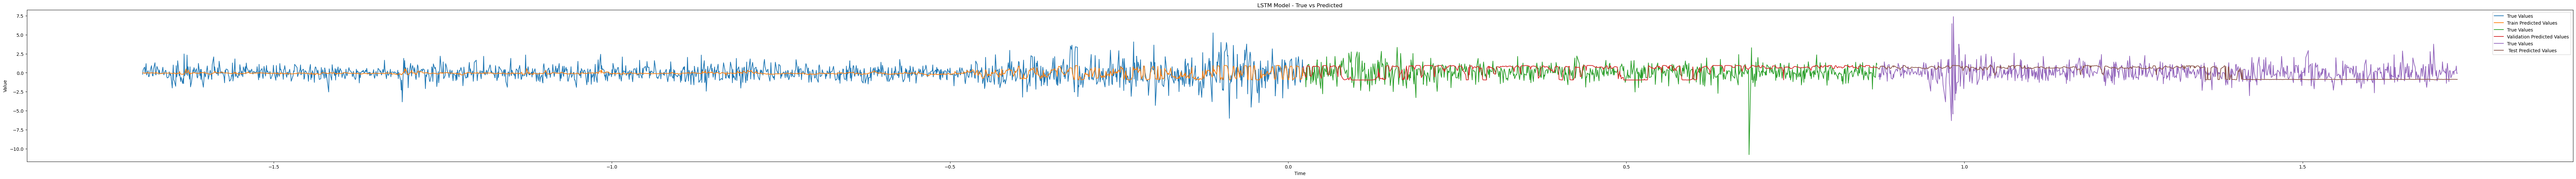

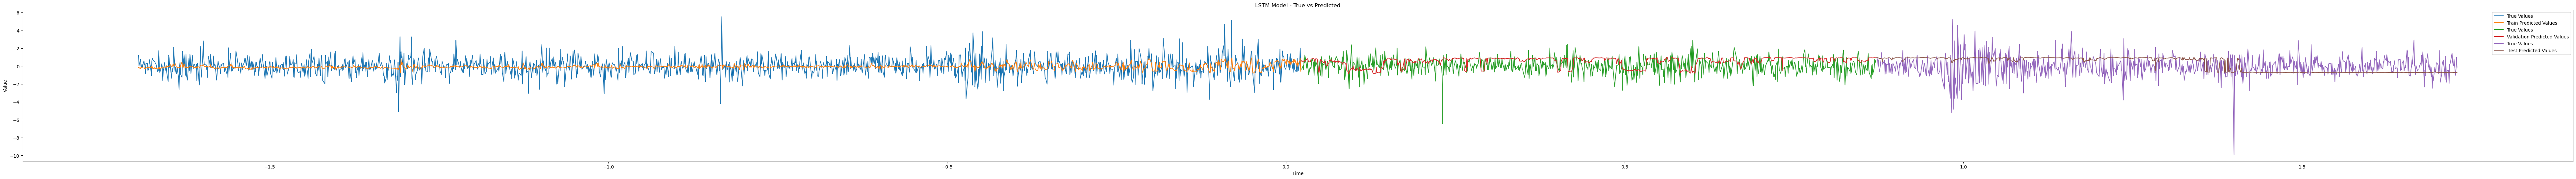

In [ ]:
split_train_targets = np.array_split(train_targets,len(train_pred[0]),axis=1)
split_train_pred = np.array_split(train_pred,len(train_pred[0]),axis=1)
split_validation_targets = np.array_split(validation_targets,len(validation_pred[0]),axis=1)
split_validation_pred = np.array_split(validation_pred,len(validation_pred[0]),axis=1)
split_test_targets = np.array_split(test_targets,len(test_pred[0]),axis=1)
split_test_pred = np.array_split(test_pred,len(test_pred[0]),axis=1)


print(len(targets))
print(train_pred)
print(split_train_targets)

for i in range(len(targets)):
    plt.figure(i,figsize=(100, 6))
    plt.plot(df['date'][rwin:rwin+len(train_targets)], split_train_targets[i], label='True Values')
    plt.plot(df['date'][rwin:rwin+len(train_targets)], split_train_pred[i], label='Train Predicted Values')
    plt.plot(df['date'][rwin+len(train_targets):rwin+len(train_targets)+len(validation_targets)], split_validation_targets[i], label='True Values')
    plt.plot(df['date'][rwin+len(train_targets):rwin+len(train_targets)+len(validation_targets)], split_validation_pred[i], label='Validation Predicted Values')
    plt.plot(df['date'][rwin+1+len(train_targets)+len(validation_targets):], split_test_targets[i], label='True Values')
    plt.plot(df['date'][rwin+len(train_targets)+len(validation_targets):], split_test_pred[i][:-1], label=' Test Predicted Values')
    plt.title('LSTM Model - True vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

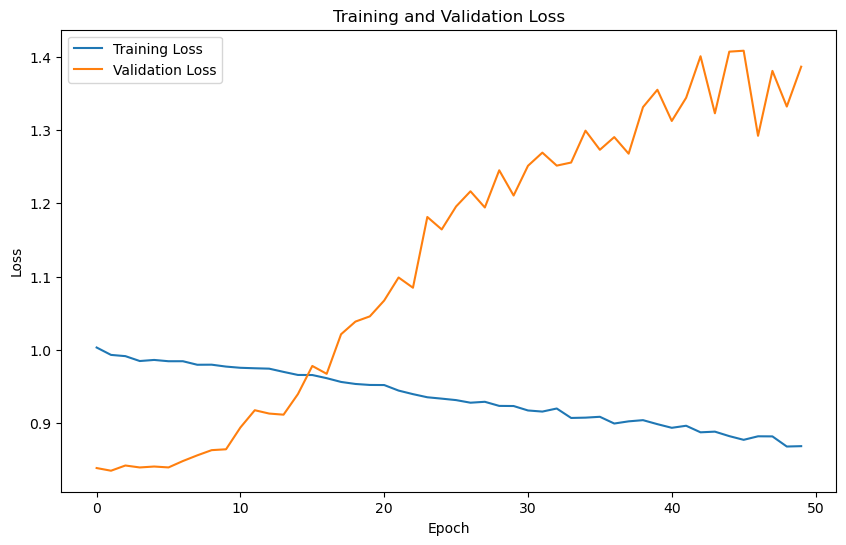

In [ ]:
plot_model(model, to_file="Plots/model.png", show_shapes=True)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#

In [ ]:
%history


#importing libraries

import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import matplotlib.pyplot as plt
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
import scipy.optimize as spo
import time
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
import requests
import json
from hyperopt import fmin, tpe, hp, Trials
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"
# class for technical indicators. I receives a dataframe and returns, for each method, 
# a new column with the values calculated based on an input column.

class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def mome

In [ ]:
# 3. Define a simple LSTM model
model = Sequential()
model.add(LSTM(len(features)*rwin, activation='tanh', input_shape=(rwin, len(features))))
model.add(Dense(len(features),activation='linear'))  # Output layer for regression
model.add(Dense(int(len(features)/2),activation='tanh'))  # Output layer for regression
model.add(Dense(len(targets),activation='tanh'))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

2024-11-03 00:26:50.905370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 00:26:50.906831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 00:26:50.908093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]
train_sequences = np.asarray(train_sequences).astype('float32')
validation_sequences = np.asarray(validation_sequences).astype('float32')
test_sequences = np.asarray(test_sequences).astype('float32')
train_targets = np.asarray(train_targets).astype('float32')
validation_targets = np.asarray(validation_targets).astype('float32')
test_targets = np.asarray(test_targets).astype('float32')

(None, 90, 6) <dtype: 'float32'>
(None, 2) <dtype: 'float32'>
lstm_96 (None, 90, 6) float32
dense_149 (None, 540) float32
dense_150 (None, 6) float32
dense_151 (None, 3) float32


In [ ]:
history = model.fit(train_sequences,train_targets, validation_data=(validation_sequences,validation_targets),epochs=100, batch_size=64)

Epoch 1/100


2024-11-03 00:26:51.190817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 00:26:51.192093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 00:26:51.193910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - ETA: 0s - loss: 1.0173

2024-11-03 00:27:02.006286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 00:27:02.007704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 00:27:02.009187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 439ms/step - loss: 1.0173 - val_loss: 0.8257
Epoch 2/100
25/25 [==============================] - 11s 457ms/step - loss: 1.0057 - val_loss: 0.8186
Epoch 3/100
25/25 [==============================] - 12s 493ms/step - loss: 1.0033 - val_loss: 0.8192
Epoch 4/100
25/25 [==============================] - 11s 434ms/step - loss: 1.0016 - val_loss: 0.8192
Epoch 5/100
25/25 [==============================] - 11s 453ms/step - loss: 0.9999 - val_loss: 0.8225
Epoch 6/100
25/25 [==============================] - 11s 437ms/step - loss: 0.9965 - val_loss: 0.8585
Epoch 7/100
25/25 [==============================] - 11s 455ms/step - loss: 1.0003 - val_loss: 0.8211
Epoch 8/100
25/25 [==============================] - 11s 436ms/step - loss: 0.9997 - val_loss: 0.8230
Epoch 9/100
25/25 [==============================] - 11s 451ms/step - loss: 0.9939 - val_loss: 0.8555
Epoch 10/100
25/25 [==============================] - 11s 440ms/step - loss: 0.9937 - val_loss

In [ ]:
train_pred = model.predict(train_sequences)
validation_pred = model.predict(validation_sequences)
test_pred = model.predict(test_sequences)

2024-11-03 00:45:14.171391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-03 00:45:14.173122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-03 00:45:14.175076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 2s 74ms/step


In [ ]:
print(validation_pred)
print(validation_pred.shape)
print(validation_targets)

[[-0.12594092  0.95293725]
 [ 0.661637   -0.68167466]
 [ 0.97578424  0.93019027]
 ...
 [-0.5958817  -0.32228798]
 [-0.12571305 -0.35156396]
 [ 0.47583264  0.06717958]]
(783, 2)
[[ 0.84418166  0.03072024]
 [-0.01491839  1.0594686 ]
 [-0.54668117 -1.1550097 ]
 ...
 [ 0.0950681   0.66167253]
 [-0.05416175 -0.9034449 ]
 [-0.06206988  0.3003032 ]]
